In [1]:
import ROOT
from ROOT import RooRealVar, RooArgSet, RooDataSet, RooAbsPdf, RooFit, TMath, RooDataHist,RooDataSet
import os
import numpy as np
import array

In [2]:
inputFiles = ["out/pippi0_fall2018_in_pass2/pippi0_fall2018_in_pass2.root","out/pippi0_spring2019_in_pass2/pippi0_spring2019_in_pass2.root"]

In [3]:
chain = ROOT.TChain("pippi0")

for f in inputFiles:
    chain.Add(f)

In [4]:
[branch.GetName() for branch in chain.GetListOfBranches()]

['hel',
 'run',
 'x',
 'eps',
 'gamma',
 'x_true',
 'Q2',
 'Q2_true',
 'z',
 'pT',
 'xF',
 'xF1',
 'xF2',
 'phi',
 'Mx',
 'Mh',
 'z_true',
 'pT_true',
 'xF_true',
 'xF1_true',
 'xF2_true',
 'phi_true',
 'Mx_true',
 'Mh_true',
 'Mdiphoton',
 'Mdiphoton_true',
 'th',
 'th_true',
 'cth',
 'cth_true']

In [9]:
chain = chain.CopyTree("Mdiphoton<0.16 && 0.115<Mdiphoton && 0.85<Mx && Mx < 1.05")

Warning in <TROOT::Append>: Replacing existing TH1: binning (Potential memory leak).


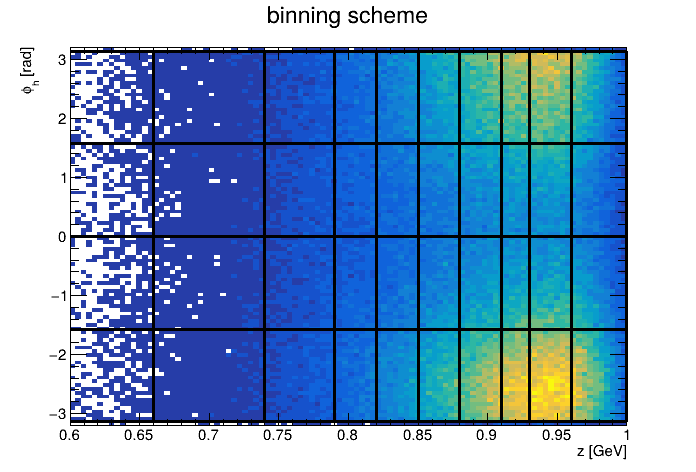

In [10]:
zbn_edges = [0.66, 0.74, 0.79, 0.82, 0.85, 0.88, 0.91, 0.93, 0.96, 1]
phibn_edges = np.linspace(-3.14,3.14,5)

c2D = ROOT.TCanvas()
c2D.SetTickx()
c2D.SetTicky()
#c2D.SetGridx()
#c2D.SetGridy()

binning = ROOT.TH2F("binning","binning scheme;z [GeV];#phi_{h} [rad]", 
                    100,0.6,1,
                    100,-3.2,3.2)

chain.Draw("phi:z>>binning")

binning.SetStats(0)
binning.Draw()

lines = []

for z in zbn_edges:
    line = ROOT.TLine(z, -3.14, z, 3.14)
    line.SetLineColor(ROOT.kBlack)
    line.SetLineWidth(3)
    line.Draw()
    lines.append(line)

for phi in phibn_edges:
    line = ROOT.TLine(0.6, phi, 1, phi)
    line.SetLineColor(ROOT.kBlack)
    line.SetLineWidth(3)
    line.Draw()
    lines.append(line)

c2D.Draw()



In [11]:
Mh = RooRealVar("Mh", "Mh", 0.4, 1.7)
Mh.setRange("fullRange",0.4,1.4)
    
mu = RooRealVar("m_{0}", "mu", 0.8,0.6, 1)
sigma = RooRealVar("#sigma", "sigma", 0.06,0.00001, 0.4)
p1 = RooRealVar("p1", "p1", 0,-5,5)
p2 = RooRealVar("p2", "p2", 0,-5,5)
p3 = RooRealVar("p3", "p3", 0,-5,5)
p4 = RooRealVar("p4", "p4", 0,-5,5)

N_sig = RooRealVar("N_{sig}", "N_sig", 10000,0,chain.GetEntries())
N_bkg = RooRealVar("N_{bkg}", "N_bkg", 10000,0,chain.GetEntries())

z = RooRealVar("z", "z",0,1)
phi = RooRealVar("phi", "phi",-3.14,3.14)
hel = RooRealVar("hel", "hel",-1,1)

[#1] INFO:Eval -- RooRealVar::setRange(Mh) new range named 'fullRange' created with bounds [0.4,1.4]


In [14]:
sig = ROOT.RooGaussian("sig","gaussian Fit",Mh,mu,sigma)
    
pars_pol = ROOT.RooArgList(p1,p2,p3,p4)
background = ROOT.RooChebychev("background", "Background", Mh, pars_pol)
    
# Combine signal and background
model_ext = ROOT.RooAddPdf("model_ext", "Signal + Background", ROOT.RooArgList(sig, background), ROOT.RooArgList(N_sig,N_bkg))

In [ ]:
for i in range(1):#len(zbn_edges) - 1):
    zmin = zbn_edges[i]
    zmax = zbn_edges[i+1]
    for j in range(1):#len(phibn_edges)-1):
        phimin = phibn_edges[i]
        phimax = phibn_edges[i+1]
        cut_str = f"{zmin}<z && z<{zmax} && {phimin}<phi && phi<{phimax}"
        neg_DS = RooDataSet("neg_DS","neg_DS",chain,ROOT.RooArgSet(Mh,z,phi,hel),f"{cut_str} && hel ==-1")
        pos_DS = RooDataSet("pos_DS","pos_DS",chain,ROOT.RooArgSet(Mh,z,phi,hel),f"{cut_str} && hel ==1")

        neg_fit_results = model_ext.fitTo(neg_DS,RooFit.Range("fullRange"),
                              RooFit.Save(),RooFit.PrintLevel(-1),Extended = True)
        pos_fit_results = model_ext.fitTo(pos_DS,RooFit.Range("fullRange"),
                              RooFit.Save(),RooFit.PrintLevel(-1),Extended = True)

In [ ]:
frame = Mh.frame(0.4,1.7)
frame.SetYTitle("Events")
neg_DS.plotOn(frame,RooFit.MarkerSize(0.5),
            RooFit.Name("data"))
model_ext.plotOn(frame,RooFit.LineStyle(ROOT.kDashed),RooFit.LineColor(ROOT.kBlack),
            RooFit.Name("totalFit"))
model_ext.plotOn(frame, RooFit.Components("background"), RooFit.LineColor(ROOT.kRed),
            RooFit.Name("chebychevFit"))
model_ext.plotOn(frame, RooFit.Components("sig"), RooFit.LineColor(ROOT.kBlue),
            RooFit.Name("sigFit"))
